## Detection of images containing vehicles or not using Convolutional Neural Networks


#### Dataset information:

- The data was collected to train a model to distinguish between images containing vehicles and images without vehicles, so the whole problem is binary classification.


The data is divided into 2 folders:
- The folder `` non-vehicles`` contains 8968 images and the folder `` vehicles`` contains 8792 images for training and testing the model.

The dataset can be found on the `` Kaggle`` platform at the link below:

- https://www.kaggle.com/brsdincer/vehicle-detection-image-set

## 1. Imports from libraries

In [13]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

tf.config.list_physical_devices('GPU')

[]

## 2. Organizing Training and Testing Dataframes

In [14]:
# Selecting Dataset Folder Paths
dir_ = Path("D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capstone\Dataset\Vehicle Detection Image Set")
filepaths = list(dir_.glob(r'**/*.png'))
# Mapping the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Paths & labels femalee eyes
filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating...
df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

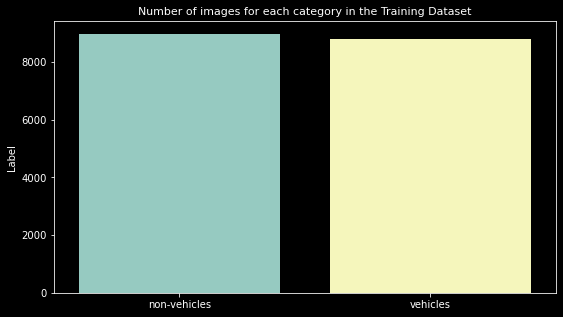

In [15]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

## 3. Observing the images

In [16]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'non-vehicles')

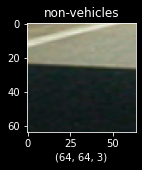

In [17]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'vehicles')

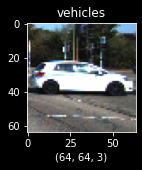

In [18]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][15])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][15])

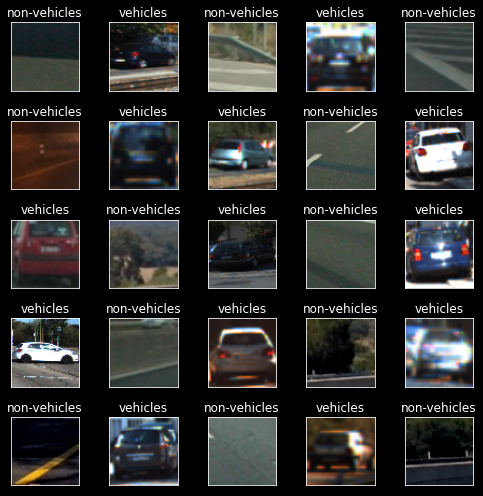

In [19]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

## 3. Dividing into training and testing sets
Now we need to convert our data into training and testing sets. We will use 90% of the images as our training data and test our model on the remaining 10% with Scikit-learn's train_test_split function.

In [20]:
trainset_df, testset_df = train_test_split(df, train_size = 0.90, random_state = 42)

display(trainset_df.head())

testset_df.head()

,File,Label
5758,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,non-vehicles
11522,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,vehicles
3143,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,vehicles
8774,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,non-vehicles
9845,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,vehicles


,File,Label
15314,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,non-vehicles
11728,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,non-vehicles
10379,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,vehicles
6323,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,vehicles
5155,D:\Grox's Vault\Laboratory\Repos\Bisa.ai_capst...,vehicles


In [21]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [22]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 15984
Number of images with malee eyes: 8076
Number of images with femalee eyes: 7908

Test Dataset:
Number of images: 1776
Number of images with malee eyes: 892
Number of images with femalee eyes: 884



## 4. Generating batches of images
In this part we will generate batches of images increasing the training data, for the test database we will just normalize the data using [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)

Parameters of ``ImageDataGenerator``:

    rescale - Transform image size (normalization of data)
    shear_range - Random geometric transformations
    zoom_range - Images that will be zoomed
    rotation_range - Degree of image rotation
    width_shift_range - Image Width Change Range
    height_shift_range - Image height change range
    horizontal_flip - Rotate images horizontally
    vertical_flip - Rotate images vertically
    validation_split - Images that have been reserved for validation (0-1)

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

## 5. Directory of training, validation and test images

Here we make the division of the image bases for training, validation and testing of the model, for that we use the [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method)

Parameters of ``flow_from_directory``:

    dataframe - Dataframe containing the images directory
    x_col - Column name containing the images directory
    y_col - Name of the column containing what we want to predict
    target_size - size of the images (remembering that it must be the same size as the input layer)
    color_mode - RGB color standard
    class_mode - binary class mode (cat/dog)
    batch_size - batch size (32)
    shuffle - Shuffle the data
    seed - optional random seed for the shuffle
    subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)

In [24]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 14386 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1598 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 1776 validated image filenames belonging to 2 classes.
Data generators are ready!


Use of callbacks to monitor models and see if metrics will improve, otherwise training is stopped.

``EarlyStopping`` parameters:

    monitor - Metrics that will be monitored
    patience - Number of times without improvement in the model, after these times the training is stopped
    restore_best_weights - Restores best weights if training is interrupted

In [25]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

## 6. Construction of the first model (Inception)
The [InceptionV3](https://keras.io/api/applications/inceptionv3/) model proposed by Szegedy et al. (2015), is a CNN architecture that seeks to solve several large-scale image recognition problems and can also be used in transfer learning problems. Its differential is the presence of convolutional characteristics extractor modules. These modules have the functionality to learn with fewer parameters that contain a greater range of information.

<p><img src = "https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png?hl=pt-br" alt></p>

###### Step 1 - Base model creation
    input_shape - Setting the height/width and RGB channels (75, 75, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [26]:
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [27]:
for layer in CNN_base_inc.layers:
    layer.trainable = False

###### Step 2 - Flattening
    Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [28]:
x = layers.Flatten()(CNN_base_inc.output)

###### Step 3 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [29]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)

###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [30]:
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

Epoch 1/25


c:\ProgramData\Anaconda3\envs\bisa_ai\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


450/450 [==============================] - 93s 199ms/step - loss: 0.1411 - accuracy: 0.9525 - val_loss: 0.0771 - val_accuracy: 0.9731
Epoch 2/25
450/450 [==============================] - 41s 92ms/step - loss: 0.0817 - accuracy: 0.9707 - val_loss: 0.0606 - val_accuracy: 0.9837
Epoch 3/25
450/450 [==============================] - 35s 77ms/step - loss: 0.0723 - accuracy: 0.9737 - val_loss: 0.0714 - val_accuracy: 0.9718
Epoch 4/25
450/450 [==============================] - 38s 83ms/step - loss: 0.0686 - accuracy: 0.9762 - val_loss: 0.0643 - val_accuracy: 0.9775
Epoch 5/25
450/450 [==============================] - 38s 84ms/step - loss: 0.0619 - accuracy: 0.9784 - val_loss: 0.0751 - val_accuracy: 0.9781
Epoch 6/25
450/450 [==============================] - 35s 78ms/step - loss: 0.0615 - accuracy: 0.9793 - val_loss: 0.0650 - val_accuracy: 0.9781
Epoch 7/25
450/450 [==============================] - 36s 81ms/step - loss: 0.0595 - accuracy: 0.9798 - val_loss: 0.0557 - val_accuracy: 0.9793
Ep

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

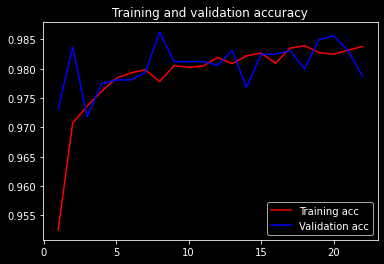

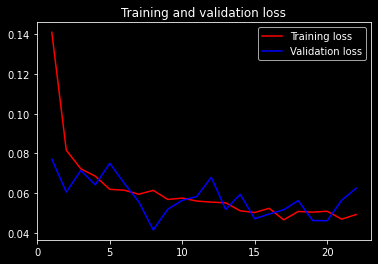

In [31]:
acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 6 - Viewing results and generating forecasts

In [32]:
score_inc = CNN_inc.evaluate(test_set)
print("Test Loss:", score_inc[0])
print("Test Accuracy:", score_inc[1])

56/56 [==============================] - 30s 548ms/step - loss: 0.0335 - accuracy: 0.9882
Test Loss: 0.03347047418355942
Test Accuracy: 0.9881756901741028


In [33]:
y_pred_inc = CNN_inc.predict(test_set)
y_pred_inc = np.round(y_pred_inc)

recall_inc = recall_score(y_test, y_pred_inc)
precision_inc = precision_score(y_test, y_pred_inc)
f1_inc = f1_score(y_test, y_pred_inc)
roc_inc = roc_auc_score(y_test, y_pred_inc)

56/56 [==============================] - 4s 53ms/step


In [34]:
print(classification_report(y_test, y_pred_inc))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       892
           1       0.98      0.99      0.99       884

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



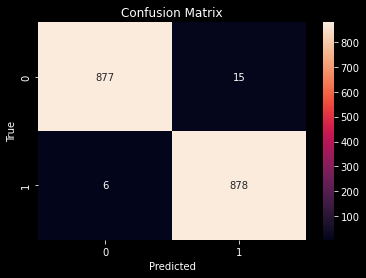

In [35]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_inc),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## 7. Construction of the second model (Xception)
The [Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception) model proposed by Chollet et al.(2016), is a CNN architecture similar to the Inception described above and, has the difference that the initiation modules were replaced by separable convolutions in depth. Xception has the same amount of parameters as InceptionV3 with a total of 36 convolutional layers. Thus, having a more efficient use of parameters.

<p><img src = "https://miro.medium.com/max/1688/1*J8dborzVBRBupJfvR7YhuA.png" alt></p>

###### Step 1 - Base model creation

    input_shape - Setting the height/width and RGB channels (75, 75, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [36]:
CNN_base_xcep = Xception(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')
CNN_base_xcep.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


###### Step 2 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [37]:
CNN_xcep = Sequential()
CNN_xcep.add(CNN_base_xcep)
CNN_xcep.add(GlobalAveragePooling2D())
CNN_xcep.add(Dense(128))
CNN_xcep.add(Dropout(0.1))
CNN_xcep.add(Dense(1, activation = 'sigmoid'))

CNN_xcep.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
______________________________________

In [38]:
plot_model(CNN_xcep, show_layer_names = True , show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [39]:
# Compilation
CNN_xcep.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_xcep_history = CNN_xcep.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_xcep = end - start
print ('\nTraining and validation time: ', time_CNN_xcep)

Epoch 1/25
450/450 [==============================] - 63s 134ms/step - loss: 0.1062 - accuracy: 0.9735 - val_loss: 0.3284 - val_accuracy: 0.9293
Epoch 2/25
450/450 [==============================] - 58s 129ms/step - loss: 0.0811 - accuracy: 0.9794 - val_loss: 0.0509 - val_accuracy: 0.9881
Epoch 3/25
450/450 [==============================] - 61s 136ms/step - loss: 0.0518 - accuracy: 0.9856 - val_loss: 0.0489 - val_accuracy: 0.9875
Epoch 4/25
450/450 [==============================] - 68s 150ms/step - loss: 0.0545 - accuracy: 0.9849 - val_loss: 0.0325 - val_accuracy: 0.9887
Epoch 5/25
450/450 [==============================] - 66s 147ms/step - loss: 0.0480 - accuracy: 0.9856 - val_loss: 0.0407 - val_accuracy: 0.9887
Epoch 6/25
450/450 [==============================] - 63s 141ms/step - loss: 0.0384 - accuracy: 0.9888 - val_loss: 0.0290 - val_accuracy: 0.9900
Epoch 7/25
450/450 [==============================] - 62s 138ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.0405 - val_ac

###### Step 5 - Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

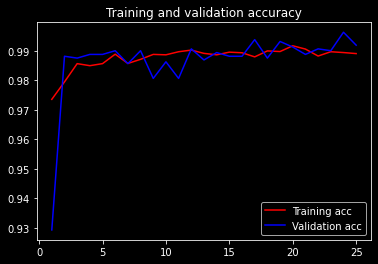

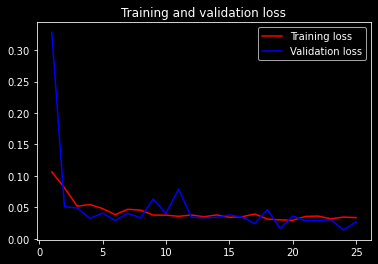

In [40]:
acc = CNN_xcep_history.history['accuracy']
val_acc = CNN_xcep_history.history['val_accuracy']
loss = CNN_xcep_history.history['loss']
val_loss = CNN_xcep_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

###### Step 8 - Viewing results and generating forecasts

In [41]:
score_xcep = CNN_xcep.evaluate(test_set)
print("Test Loss:", score_xcep[0])
print("Test Accuracy:", score_xcep[1])

56/56 [==============================] - 6s 109ms/step - loss: 0.0269 - accuracy: 0.9876
Test Loss: 0.02688651531934738
Test Accuracy: 0.9876126050949097


In [42]:
y_pred_xcep = CNN_xcep.predict(test_set)
y_pred_xcep = np.round(y_pred_xcep)

recall_xcep = recall_score(y_test, y_pred_xcep)
precision_xcep = precision_score(y_test, y_pred_xcep)
f1_xcep = f1_score(y_test, y_pred_xcep)
roc_xcep = roc_auc_score(y_test, y_pred_xcep)

56/56 [==============================] - 7s 117ms/step


In [43]:
print(classification_report(y_test, y_pred_xcep))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.99      0.99      0.99       884

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



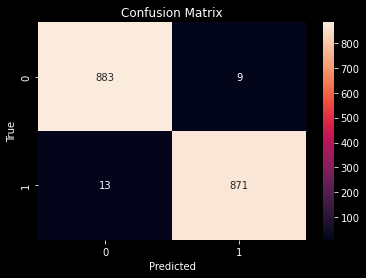

In [44]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_xcep),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## 8. Construction of the third model (MobileNet)
The MobileNet model proposed by Howard et al. (2017), is a CNN architecture that were created to perform computer vision tasks on mobile devices and embedded systems. They are based on in-depth separable convolution operations, which lessens the burden of operations in the first layers.

<p><img src = "https://nitheshsinghsanjay.github.io/images/mobtiny_fig.PNG" alt></p>

###### Step 1 - Base model creation

    input_shape - Setting the height/width and RGB channels (75, 75, 3)
    include_top - Fully connected layer will not be included on top
    weights - Pre-training using imagenet

In [45]:
CNN_base_mobilenet = MobileNet(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [46]:
for layer in CNN_base_mobilenet.layers:
    layer.trainable = False

###### Step 2 - Dense Neural Networks

    Dense - All connected neurons
    units - Number of neurons that are part of the hidden layer
    activation - Activation function that will be inserted
    Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)

In [47]:
CNN_mobilenet = Sequential()
CNN_mobilenet.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet.add(CNN_base_mobilenet)
CNN_mobilenet.add(BatchNormalization())
CNN_mobilenet.add(GlobalAveragePooling2D())
CNN_mobilenet.add(Dropout(0.5))
CNN_mobilenet.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_98 (Bat  (None, 75, 75, 3)        12        
 chNormalization)                                                
                                                                 
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 batch_normalization_99 (Bat  (None, 2, 2, 1024)       4096      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [48]:
plot_model(CNN_mobilenet, show_layer_names = True , show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


###### Step 4 - Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [49]:
# Compilation
CNN_mobilenet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_history = CNN_mobilenet.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet)

Epoch 1/25
450/450 [==============================] - 38s 80ms/step - loss: 0.1679 - accuracy: 0.9322 - val_loss: 0.0573 - val_accuracy: 0.9812
Epoch 2/25
450/450 [==============================] - 35s 78ms/step - loss: 0.0805 - accuracy: 0.9721 - val_loss: 0.0478 - val_accuracy: 0.9831
Epoch 3/25
450/450 [==============================] - 36s 81ms/step - loss: 0.0674 - accuracy: 0.9759 - val_loss: 0.0331 - val_accuracy: 0.9894
Epoch 4/25
450/450 [==============================] - 36s 81ms/step - loss: 0.0638 - accuracy: 0.9775 - val_loss: 0.0428 - val_accuracy: 0.9875
Epoch 5/25
450/450 [==============================] - 35s 78ms/step - loss: 0.0651 - accuracy: 0.9759 - val_loss: 0.0323 - val_accuracy: 0.9894
Epoch 6/25
450/450 [==============================] - 36s 81ms/step - loss: 0.0656 - accuracy: 0.9772 - val_loss: 0.0324 - val_accuracy: 0.9900
Epoch 7/25
450/450 [==============================] - 36s 80ms/step - loss: 0.0627 - accuracy: 0.9756 - val_loss: 0.0227 - val_accuracy:

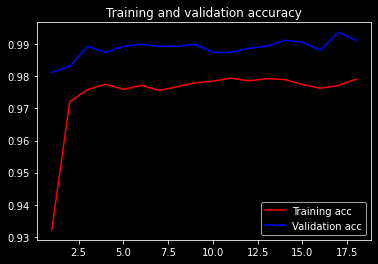

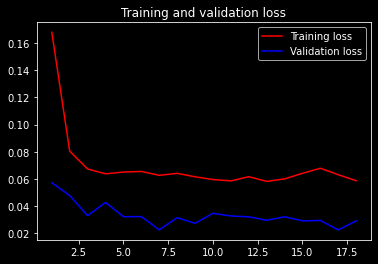

In [50]:
acc = CNN_mobilenet_history.history['accuracy']
val_acc = CNN_mobilenet_history.history['val_accuracy']
loss = CNN_mobilenet_history.history['loss']
val_loss = CNN_mobilenet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [51]:
score_mn = CNN_mobilenet.evaluate(test_set)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

56/56 [==============================] - 1s 23ms/step - loss: 0.0166 - accuracy: 0.9938
Test Loss: 0.016586432233452797
Test Accuracy: 0.9938063025474548


In [52]:
y_pred_mn = CNN_mobilenet.predict(test_set)
y_pred_mn = np.round(y_pred_mn)

recall_mn = recall_score(y_test, y_pred_mn)
precision_mn = precision_score(y_test, y_pred_mn)
f1_mn = f1_score(y_test, y_pred_mn)
roc_mn = roc_auc_score(y_test, y_pred_mn)

56/56 [==============================] - 2s 21ms/step


In [53]:
print(classification_report(y_test, y_pred_mn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.99      0.99      0.99       884

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



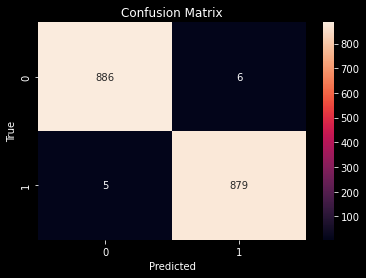

In [54]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# Mobilenet V2

In [55]:
CNN_base_mobilenetv2 = MobileNetV2(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

In [56]:
for layer in CNN_base_mobilenet.layers:
    layer.trainable = False

In [57]:
CNN_mobilenet_v2 = Sequential()
CNN_mobilenet_v2.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet_v2.add(CNN_base_mobilenetv2)
CNN_mobilenet_v2.add(BatchNormalization())
CNN_mobilenet_v2.add(GlobalAveragePooling2D())
CNN_mobilenet_v2.add(Dropout(0.5))
CNN_mobilenet_v2.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet_v2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_100 (Ba  (None, 75, 75, 3)        12        
 tchNormalization)                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 3, 3, 1280)       2257984   
 ional)                                                          
                                                                 
 batch_normalization_101 (Ba  (None, 3, 3, 1280)       5120      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)             

In [58]:
# Compilation
CNN_mobilenet_v2.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_v2_history = CNN_mobilenet_v2.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet_v2 = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet_v2)

Epoch 1/25
450/450 [==============================] - 159s 345ms/step - loss: 0.0542 - accuracy: 0.9822 - val_loss: 0.2230 - val_accuracy: 0.9912
Epoch 2/25
450/450 [==============================] - 138s 307ms/step - loss: 0.0254 - accuracy: 0.9928 - val_loss: 0.0643 - val_accuracy: 0.9950
Epoch 3/25
450/450 [==============================] - 150s 333ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.0643 - val_accuracy: 0.9981
Epoch 4/25
450/450 [==============================] - 164s 363ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 17.6835 - val_accuracy: 0.7741
Epoch 5/25
450/450 [==============================] - 170s 378ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.3216 - val_accuracy: 0.9900
Epoch 6/25
450/450 [==============================] - 151s 334ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.1708 - val_accuracy: 0.9919
Epoch 7/25
450/450 [==============================] - 167s 371ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.3635 

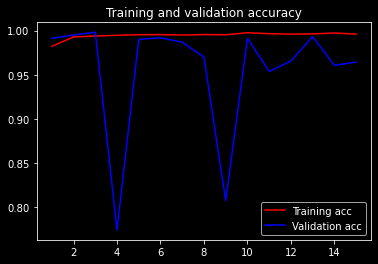

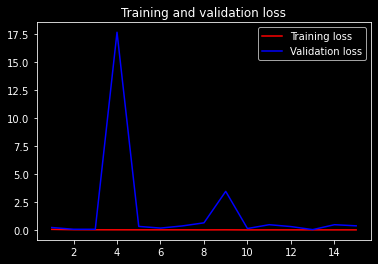

In [59]:
acc = CNN_mobilenet_v2_history.history['accuracy']
val_acc = CNN_mobilenet_v2_history.history['val_accuracy']
loss = CNN_mobilenet_v2_history.history['loss']
val_loss = CNN_mobilenet_v2_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [60]:
score_mobilenet_v2 = CNN_mobilenet_v2.evaluate(test_set)
print("Test Loss:", score_mobilenet_v2[0])
print("Test Accuracy:", score_mobilenet_v2[1])

56/56 [==============================] - 1s 24ms/step - loss: 0.1872 - accuracy: 0.9921
Test Loss: 0.18718065321445465
Test Accuracy: 0.9921171069145203


In [61]:
y_pred_mobilenet_v2 = CNN_mobilenet_v2.predict(test_set)
y_pred_mobilenet_v2 = np.round(y_pred_mobilenet_v2)

recall_mobilenet_v2 = recall_score(y_test, y_pred_mobilenet_v2)
precision_mobilenet_v2 = precision_score(y_test, y_pred_mobilenet_v2)
f1_mobilenet_v2 = f1_score(y_test, y_pred_mobilenet_v2)
roc_mobilenet_v2 = roc_auc_score(y_test, y_pred_mobilenet_v2)

56/56 [==============================] - 2s 23ms/step


In [62]:
print(classification_report(y_test, y_pred_mobilenet_v2))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       892
           1       0.99      1.00      0.99       884

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



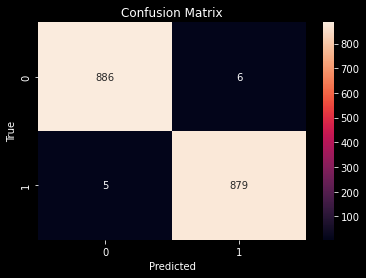

In [63]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# VGG 16

In [64]:
CNN_base_vgg16 = VGG16(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

58889256/58889256 [==============================] - 5s 0us/step


In [65]:
CNN_vgg16 = Sequential()
CNN_vgg16.add(CNN_base_vgg16)
CNN_vgg16.add(Flatten())
CNN_vgg16.add(Dropout(0.5))
CNN_vgg16.add(Dense(1, activation = 'sigmoid'))

CNN_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 14,716,737
Trainable params: 14,716,737
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Compilation
CNN_vgg16.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_vgg16_history = CNN_vgg16.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_vgg16 = end - start
print ('\nTraining and validation time: ', time_CNN_vgg16)

Epoch 1/25
450/450 [==============================] - 360s 798ms/step - loss: 0.2166 - accuracy: 0.9146 - val_loss: 0.0752 - val_accuracy: 0.9718
Epoch 2/25
450/450 [==============================] - 348s 773ms/step - loss: 0.0850 - accuracy: 0.9693 - val_loss: 0.0586 - val_accuracy: 0.9806
Epoch 3/25
450/450 [==============================] - 338s 751ms/step - loss: 0.0904 - accuracy: 0.9696 - val_loss: 0.1547 - val_accuracy: 0.9562
Epoch 4/25
450/450 [==============================] - 347s 772ms/step - loss: 0.1305 - accuracy: 0.9614 - val_loss: 0.0776 - val_accuracy: 0.9750
Epoch 5/25
450/450 [==============================] - 343s 763ms/step - loss: 0.5175 - accuracy: 0.8593 - val_loss: 0.3603 - val_accuracy: 0.8411
Epoch 6/25
450/450 [==============================] - 342s 759ms/step - loss: 0.1853 - accuracy: 0.9315 - val_loss: 0.0948 - val_accuracy: 0.9618
Epoch 7/25
450/450 [==============================] - 347s 771ms/step - loss: 0.0936 - accuracy: 0.9677 - val_loss: 0.0689 -

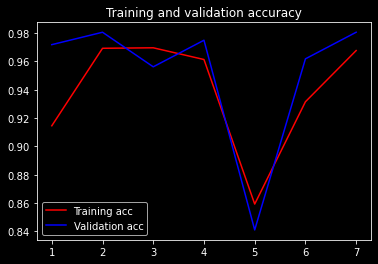

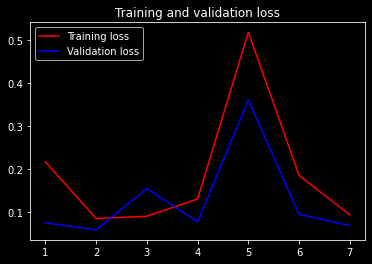

In [67]:
acc = CNN_vgg16_history.history['accuracy']
val_acc = CNN_vgg16_history.history['val_accuracy']
loss = CNN_vgg16_history.history['loss']
val_loss = CNN_vgg16_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [68]:
score_vgg16 = CNN_vgg16.evaluate(test_set)
print("Test Loss:", score_vgg16[0])
print("Test Accuracy:", score_vgg16[1])

56/56 [==============================] - 13s 233ms/step - loss: 0.0558 - accuracy: 0.9803
Test Loss: 0.05580415949225426
Test Accuracy: 0.980292797088623


In [69]:
y_pred_vgg16 = CNN_vgg16.predict(test_set)
y_pred_vgg16 = np.round(y_pred_vgg16)

recall_vgg16 = recall_score(y_test, y_pred_vgg16)
precision_vgg16 = precision_score(y_test, y_pred_vgg16)
f1_vgg16 = f1_score(y_test, y_pred_vgg16)
roc_vgg16 = roc_auc_score(y_test, y_pred_vgg16)

56/56 [==============================] - 13s 228ms/step


In [70]:
print(classification_report(y_test, y_pred_vgg16))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       892
           1       0.98      0.98      0.98       884

    accuracy                           0.98      1776
   macro avg       0.98      0.98      0.98      1776
weighted avg       0.98      0.98      0.98      1776



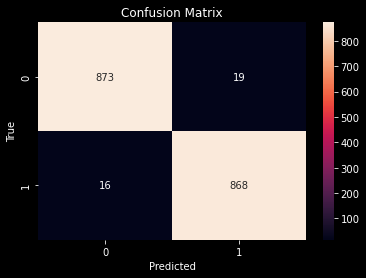

In [71]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_vgg16),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# VGG 19

In [72]:
CNN_base_vgg19 = VGG19(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

80134624/80134624 [==============================] - 5s 0us/step


In [73]:
CNN_vgg19 = Sequential()
CNN_vgg19.add(CNN_base_vgg19)
CNN_vgg19.add(Flatten())
CNN_vgg19.add(Dropout(0.5))
CNN_vgg19.add(Dense(1, activation = 'sigmoid'))

CNN_vgg19.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,026,433
Trainable params: 20,026,433
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Compilation
CNN_vgg19.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_vgg19_history = CNN_vgg19.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_vgg19 = end - start
print ('\nTraining and validation time: ', time_CNN_vgg19)

Epoch 1/25
450/450 [==============================] - 436s 967ms/step - loss: 0.8592 - accuracy: 0.7074 - val_loss: 0.1397 - val_accuracy: 0.9487
Epoch 2/25
450/450 [==============================] - 426s 946ms/step - loss: 0.1831 - accuracy: 0.9342 - val_loss: 0.0962 - val_accuracy: 0.9693
Epoch 3/25
450/450 [==============================] - 431s 957ms/step - loss: 0.0885 - accuracy: 0.9692 - val_loss: 0.0978 - val_accuracy: 0.9643
Epoch 4/25
450/450 [==============================] - 429s 953ms/step - loss: 0.0738 - accuracy: 0.9765 - val_loss: 0.0705 - val_accuracy: 0.9775
Epoch 5/25
450/450 [==============================] - 423s 940ms/step - loss: 0.3602 - accuracy: 0.8109 - val_loss: 0.0902 - val_accuracy: 0.9662
Epoch 6/25
450/450 [==============================] - 439s 974ms/step - loss: 0.6832 - accuracy: 0.6424 - val_loss: 0.5224 - val_accuracy: 0.7610
Epoch 7/25
450/450 [==============================] - 413s 918ms/step - loss: 0.2609 - accuracy: 0.9093 - val_loss: 0.2129 -

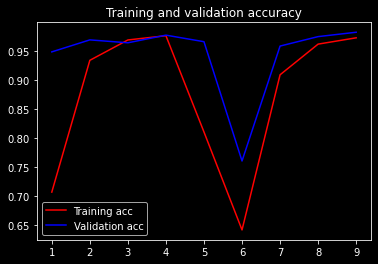

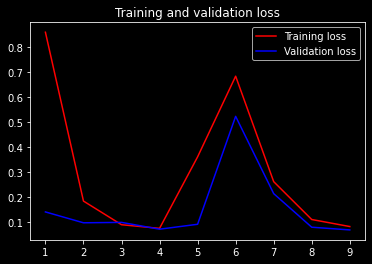

In [75]:
acc = CNN_vgg19_history.history['accuracy']
val_acc = CNN_vgg19_history.history['val_accuracy']
loss = CNN_vgg19_history.history['loss']
val_loss = CNN_vgg19_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [76]:
score_vgg19 = CNN_vgg19.evaluate(test_set)
print("Test Loss:", score_vgg19[0])
print("Test Accuracy:", score_vgg19[1])

56/56 [==============================] - 16s 278ms/step - loss: 0.0701 - accuracy: 0.9758
Test Loss: 0.07007116079330444
Test Accuracy: 0.9757882952690125


In [77]:
y_pred_vgg19 = CNN_vgg19.predict(test_set)
y_pred_vgg19 = np.round(y_pred_vgg19)

recall_vgg19 = recall_score(y_test, y_pred_vgg19)
precision_vgg19 = precision_score(y_test, y_pred_vgg19)
f1_vgg19 = f1_score(y_test, y_pred_vgg19)
roc_vgg19 = roc_auc_score(y_test, y_pred_vgg19)

56/56 [==============================] - 15s 270ms/step


In [78]:
print(classification_report(y_test, y_pred_vgg19))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       892
           1       1.00      0.95      0.98       884

    accuracy                           0.98      1776
   macro avg       0.98      0.98      0.98      1776
weighted avg       0.98      0.98      0.98      1776



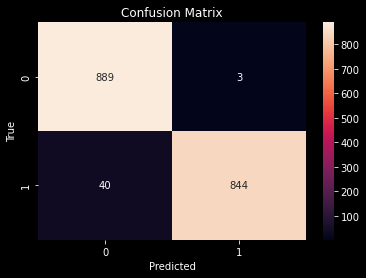

In [79]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_vgg19),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# Efficientnet (B7)

In [80]:
CNN_base_efficientnet = EfficientNetB7(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

258076736/258076736 [==============================] - 12s 0us/step


In [81]:
CNN_efficientnet = Sequential()
CNN_efficientnet.add(CNN_base_efficientnet)
CNN_efficientnet.add(Flatten())
CNN_efficientnet.add(Dropout(0.5))
CNN_efficientnet.add(Dense(1, activation = 'sigmoid'))

CNN_efficientnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 flatten_3 (Flatten)         (None, 23040)             0         
                                                                 
 dropout_6 (Dropout)         (None, 23040)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 23041     
                                                                 
Total params: 64,120,728
Trainable params: 63,810,001
Non-trainable params: 310,727
_________________________________________________________________


In [82]:
# Compilation
CNN_efficientnet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_efficientnet_history = CNN_efficientnet.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_efficientnet = end - start
print ('\nTraining and validation time: ', time_CNN_efficientnet)

Epoch 1/25
450/450 [==============================] - 887s 2s/step - loss: 0.1059 - accuracy: 0.9653 - val_loss: 4.9880 - val_accuracy: 0.5213
Epoch 2/25
450/450 [==============================] - 863s 2s/step - loss: 0.0563 - accuracy: 0.9835 - val_loss: 1.0649 - val_accuracy: 0.7040
Epoch 3/25
450/450 [==============================] - 858s 2s/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 2.3365 - val_accuracy: 0.6627
Epoch 4/25
450/450 [==============================] - 858s 2s/step - loss: 0.0291 - accuracy: 0.9913 - val_loss: 0.9943 - val_accuracy: 0.8492
Epoch 5/25
450/450 [==============================] - 859s 2s/step - loss: 0.0289 - accuracy: 0.9917 - val_loss: 10.2311 - val_accuracy: 0.5207
Epoch 6/25
450/450 [==============================] - 858s 2s/step - loss: 0.0245 - accuracy: 0.9926 - val_loss: 0.1553 - val_accuracy: 0.9487
Epoch 7/25
450/450 [==============================] - 847s 2s/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.9692 - val_accuracy: 0.851

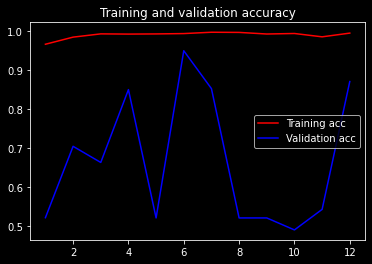

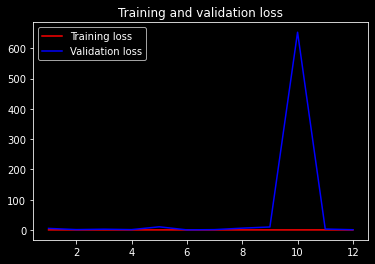

In [83]:
acc = CNN_efficientnet_history.history['accuracy']
val_acc = CNN_efficientnet_history.history['val_accuracy']
loss = CNN_efficientnet_history.history['loss']
val_loss = CNN_efficientnet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [84]:
score_efficientnet = CNN_efficientnet.evaluate(test_set)
print("Test Loss:", score_efficientnet[0])
print("Test Accuracy:", score_efficientnet[1])

56/56 [==============================] - 14s 245ms/step - loss: 1.1719 - accuracy: 0.8311
Test Loss: 1.1719125509262085
Test Accuracy: 0.8310810923576355


In [85]:
y_pred_efficientnet = CNN_efficientnet.predict(test_set)
y_pred_efficientnet = np.round(y_pred_efficientnet)

recall_efficientnet = recall_score(y_test, y_pred_efficientnet)
precision_efficientnet = precision_score(y_test, y_pred_efficientnet)
f1_efficientnet = f1_score(y_test, y_pred_efficientnet)
roc_efficientnet = roc_auc_score(y_test, y_pred_efficientnet)

56/56 [==============================] - 19s 256ms/step


In [86]:
print(classification_report(y_test, y_pred_efficientnet))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       892
           1       1.00      0.66      0.80       884

    accuracy                           0.83      1776
   macro avg       0.87      0.83      0.83      1776
weighted avg       0.87      0.83      0.83      1776



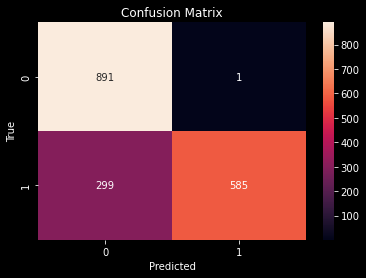

In [87]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_efficientnet),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# Efficientnet V2 (L)

In [88]:
CNN_base_efficientnet_v2 = EfficientNetV2L(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

473176280/473176280 [==============================] - 21s 0us/step


In [89]:
CNN_efficientnet_v2 = Sequential()
CNN_efficientnet_v2.add(CNN_base_efficientnet_v2)
CNN_efficientnet_v2.add(Flatten())
CNN_efficientnet_v2.add(Dropout(0.5))
CNN_efficientnet_v2.add(Dense(1, activation = 'sigmoid'))

CNN_efficientnet_v2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 3, 3, 1280)       117746848 
 l)                                                              
                                                                 
 flatten_4 (Flatten)         (None, 11520)             0         
                                                                 
 dropout_7 (Dropout)         (None, 11520)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 11521     
                                                                 
Total params: 117,758,369
Trainable params: 117,245,793
Non-trainable params: 512,576
_________________________________________________________________


In [90]:
# Compilation
CNN_efficientnet_v2.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_efficientnet_v2_history = CNN_efficientnet_v2.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_efficientnet_v2 = end - start
print ('\nTraining and validation time: ', time_CNN_efficientnet_v2)

Epoch 1/25
450/450 [==============================] - 840s 2s/step - loss: 0.1486 - accuracy: 0.9483 - val_loss: 0.4829 - val_accuracy: 0.8536
Epoch 2/25
450/450 [==============================] - 809s 2s/step - loss: 0.0968 - accuracy: 0.9666 - val_loss: 0.3795 - val_accuracy: 0.8905
Epoch 3/25
450/450 [==============================] - 706s 2s/step - loss: 0.0654 - accuracy: 0.9795 - val_loss: 0.5647 - val_accuracy: 0.8930
Epoch 4/25
450/450 [==============================] - 746s 2s/step - loss: 0.0492 - accuracy: 0.9835 - val_loss: 1.1699 - val_accuracy: 0.7309
Epoch 5/25
450/450 [==============================] - 771s 2s/step - loss: 0.0426 - accuracy: 0.9854 - val_loss: 0.2165 - val_accuracy: 0.9168
Epoch 6/25
450/450 [==============================] - 759s 2s/step - loss: 0.1151 - accuracy: 0.9625 - val_loss: 1.1268 - val_accuracy: 0.6902
Epoch 7/25
450/450 [==============================] - 766s 2s/step - loss: 0.0607 - accuracy: 0.9810 - val_loss: 0.7748 - val_accuracy: 0.8129

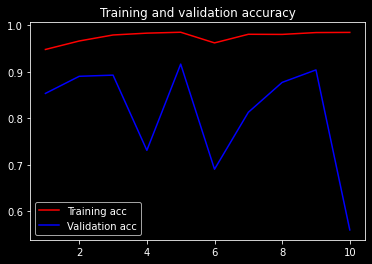

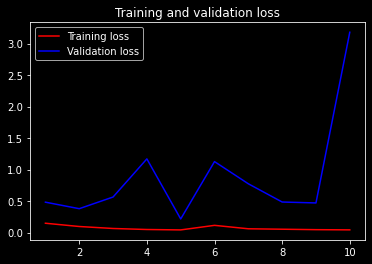

In [91]:
acc = CNN_efficientnet_v2_history.history['accuracy']
val_acc = CNN_efficientnet_v2_history.history['val_accuracy']
loss = CNN_efficientnet_v2_history.history['loss']
val_loss = CNN_efficientnet_v2_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [92]:
score_efficientnet_v2 = CNN_efficientnet_v2.evaluate(test_set)
print("Test Loss:", score_efficientnet_v2[0])
print("Test Accuracy:", score_efficientnet_v2[1])

56/56 [==============================] - 22s 387ms/step - loss: 0.2438 - accuracy: 0.9105
Test Loss: 0.2437690943479538
Test Accuracy: 0.9104729890823364


In [93]:
y_pred_efficientnet_v2 = CNN_efficientnet_v2.predict(test_set)
y_pred_efficientnet_v2 = np.round(y_pred_efficientnet_v2)

recall_efficientnet_v2 = recall_score(y_test, y_pred_efficientnet_v2)
precision_efficientnet_v2 = precision_score(y_test, y_pred_efficientnet_v2)
f1_efficientnet_v2 = f1_score(y_test, y_pred_efficientnet_v2)
roc_efficientnet_v2 = roc_auc_score(y_test, y_pred_efficientnet_v2)

56/56 [==============================] - 27s 404ms/step


In [94]:
print(classification_report(y_test, y_pred_efficientnet_v2))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       892
           1       1.00      0.82      0.90       884

    accuracy                           0.91      1776
   macro avg       0.92      0.91      0.91      1776
weighted avg       0.92      0.91      0.91      1776



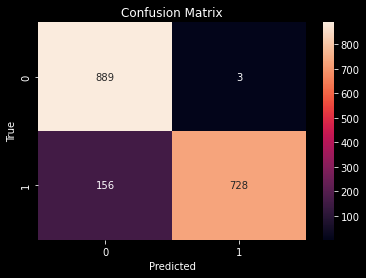

In [95]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_efficientnet_v2),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## 9. Viewing the results of all models

In [96]:
models= [('Inception', time_CNN_inc, np.mean(CNN_inc_history.history['accuracy']), np.mean(CNN_inc_history.history['val_accuracy'])),
         ('Xception', time_CNN_xcep, np.mean(CNN_xcep_history.history['accuracy']), np.mean(CNN_xcep_history.history['val_accuracy'])),
         ('MobileNet', time_CNN_mobilenet, np.mean(CNN_mobilenet_history.history['accuracy']), np.mean(CNN_mobilenet_history.history['val_accuracy'])),
         ('MobileNet V2', time_CNN_mobilenet_v2, np.mean(CNN_mobilenet_v2_history.history['accuracy']), np.mean(CNN_mobilenet_v2_history.history['val_accuracy'])),
         ('VGG16', time_CNN_vgg16, np.mean(CNN_vgg16_history.history['accuracy']), np.mean(CNN_vgg16_history.history['val_accuracy'])),
         ('VGG19', time_CNN_vgg19, np.mean(CNN_vgg19_history.history['accuracy']), np.mean(CNN_vgg19_history.history['val_accuracy'])),
         ('Efficientnet ', time_CNN_efficientnet, np.mean(CNN_efficientnet_history.history['accuracy']), np.mean(CNN_efficientnet_history.history['val_accuracy'])),
         ('Efficientnet V2', time_CNN_efficientnet_v2, np.mean(CNN_efficientnet_v2_history.history['accuracy']), np.mean(CNN_efficientnet_v2_history.history['val_accuracy']))]

df_all_models = pd.DataFrame(models, columns = ['Model', 'Time', 'Training accuracy (%)', 'Validation Accuracy (%)'])

df_all_models

,Model,Time,Training accuracy (%),Validation Accuracy (%)
0,Inception,0 days 00:13:58.393952,0.979001,0.980572
1,Xception,0 days 00:24:51.411885,0.987610,0.986458
2,MobileNet,0 days 00:10:51.504925,0.974783,0.988736
3,MobileNet V2,0 days 00:38:45.378137,0.994629,0.955528
4,VGG16,0 days 00:40:25.461859,0.939048,0.952441
5,VGG19,0 days 01:03:52.172559,0.876083,0.944792
6,Efficientnet,0 days 02:52:29.111851,0.989208,0.666823
7,Efficientnet V2,0 days 02:08:25.764374,0.975719,0.812891


In [97]:
models = [('Inception', score_inc[1], recall_inc, precision_inc, f1_inc, roc_inc),
          ('Xception', score_xcep[1], recall_xcep, precision_xcep, f1_xcep, roc_xcep),
          ('MobileNet', score_mn[1], recall_mn, precision_mn, f1_mn, roc_mn),
          ('MobileNet V2', score_mobilenet_v2[1], recall_mobilenet_v2, precision_mobilenet_v2, f1_mobilenet_v2, roc_mobilenet_v2),
          ('VGG16', score_vgg16[1], recall_vgg16, precision_vgg16, f1_vgg16, roc_vgg16),
          ('VGG19', score_vgg19[1], recall_vgg19, precision_vgg19, f1_vgg19, roc_vgg19),
          ('Efficientnet', score_efficientnet[1], recall_efficientnet, precision_efficientnet, f1_efficientnet, roc_efficientnet),
          ('Efficientnet V2', score_efficientnet_v2[1], recall_efficientnet_v2, precision_efficientnet_v2, f1_efficientnet_v2, roc_efficientnet_v2)]

df_all_models_testset = pd.DataFrame(models, columns = ['Model', 'Test accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 (%)', 'AUC'])

df_all_models_testset

,Model,Test accuracy (%),Recall (%),Precision (%),F1 (%),AUC
0,Inception,0.988176,0.993213,0.983203,0.988182,0.988198
1,Xception,0.987613,0.985294,0.989773,0.987528,0.987602
2,MobileNet,0.993806,0.994344,0.993220,0.993782,0.993809
3,MobileNet V2,0.992117,0.996606,0.987668,0.992117,0.992137
4,VGG16,0.980293,0.981900,0.978579,0.980237,0.980300
5,VGG19,0.975788,0.954751,0.996458,0.975159,0.975694
6,Efficientnet,0.831081,0.661765,0.998294,0.795918,0.830322
7,Efficientnet V2,0.910473,0.823529,0.995896,0.901548,0.910083


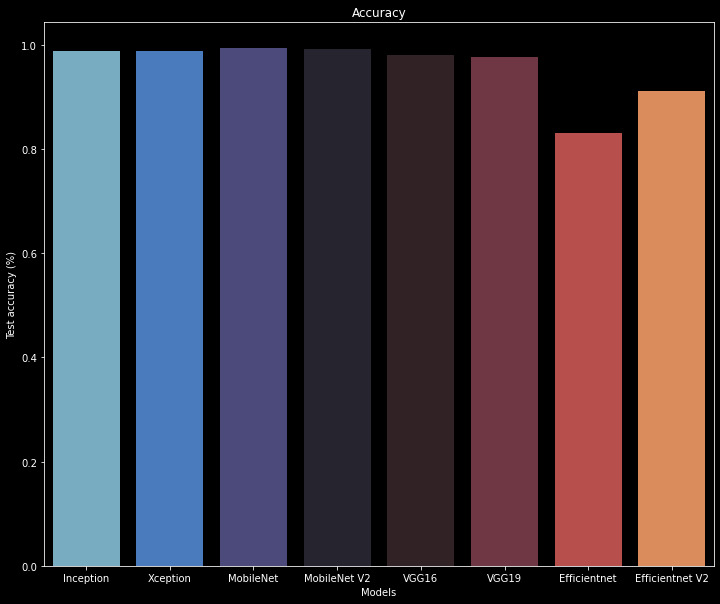

In [98]:
plt.subplots(figsize=(12, 10))
sns.barplot(y = df_all_models_testset['Test accuracy (%)'], x = df_all_models_testset['Model'], palette = 'icefire')
plt.xlabel("Models")
plt.title('Accuracy')
plt.show()

In [99]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

fpr_inc, tpr_inc, _ = roc_curve(y_test, y_pred_inc)
fpr_xcep, tpr_xcep, _ = roc_curve(y_test, y_pred_xcep)
fpr_mn, tpr_mn, _ = roc_curve(y_test, y_pred_mn)
fpr_mobilenet_v2, tpr_mobilenet_v2, _ = roc_curve(y_test, y_pred_mobilenet_v2)
fpr_vgg16, tpr_vgg16, _ = roc_curve(y_test, y_pred_vgg16)
fpr_vgg19, tpr_vgg19, _ = roc_curve(y_test, y_pred_vgg19)
fpr_efficientnet, tpr_efficientnet, _ = roc_curve(y_test, y_pred_efficientnet)
fpr_efficientnet_v2, tpr_efficientnet_v2, _ = roc_curve(y_test, y_pred_efficientnet_v2)

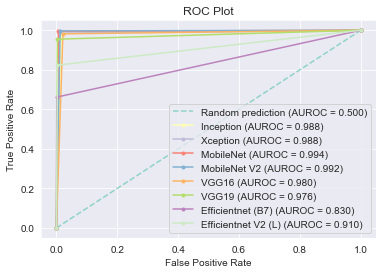

In [100]:
sns.set_style('darkgrid')

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

plt.plot(fpr_inc, tpr_inc, marker='.', label='Inception (AUROC = %0.3f)' % roc_inc)
plt.plot(fpr_xcep, tpr_xcep, marker='.', label='Xception (AUROC = %0.3f)' % roc_xcep)
plt.plot(fpr_mn, tpr_mn, marker='.', label='MobileNet (AUROC = %0.3f)' % roc_mn)
plt.plot(fpr_mobilenet_v2, tpr_mobilenet_v2, marker='.', label='MobileNet V2 (AUROC = %0.3f)' % roc_mobilenet_v2)
plt.plot(fpr_vgg16, tpr_vgg16, marker='.', label='VGG16 (AUROC = %0.3f)' % roc_vgg16)
plt.plot(fpr_vgg19, tpr_vgg19, marker='.', label='VGG19 (AUROC = %0.3f)' % roc_vgg19)
plt.plot(fpr_efficientnet, tpr_efficientnet, marker='.', label='Efficientnet (B7) (AUROC = %0.3f)' % roc_efficientnet)
plt.plot(fpr_efficientnet_v2, tpr_efficientnet_v2, marker='.', label='Efficientnet V2 (L) (AUROC = %0.3f)' % roc_efficientnet_v2)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

In [101]:
test_set.class_indices

{'non-vehicles': 0, 'vehicles': 1}

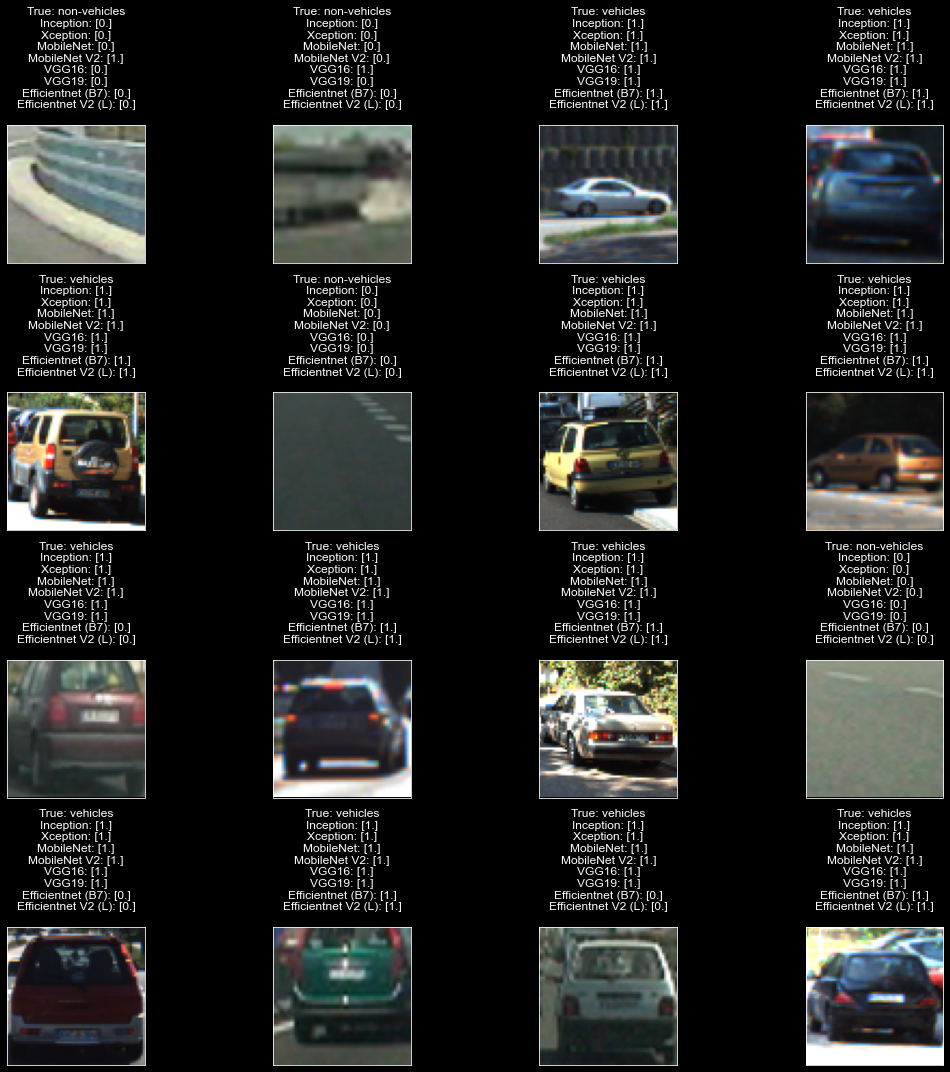

In [103]:
plt.style.use("dark_background")


fig, axes = plt.subplots(nrows = 4,
                         ncols = 4,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    ax.set_title(f"True: {testset_df.Label.iloc[i]}\nInception: {y_pred_inc[i]}\nXception: {y_pred_xcep[i]}\nMobileNet: {y_pred_mn[i]}\nMobileNet V2: {y_pred_mobilenet_v2[i]}\nVGG16: {y_pred_vgg16[i]}\nVGG19: {y_pred_vgg19[i]}\nEfficientnet (B7): {y_pred_efficientnet[i]}\nEfficientnet V2 (L): {y_pred_efficientnet[i]}\n")
plt.tight_layout()
plt.show()